In [1]:
import mxnet as mx
print(mx.__version__)

1.0.0


/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, gluon, autograd
from mxnet.gluon import nn, rnn

mx.random.seed(1)
ctx = mx.cpu(0)

import aifc # ReadAIFF

import math
import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# from matplotlib import mlab
# import matplotlib

%matplotlib inline




## 1. DATASET

#### Load Data

In [3]:
# Set path to directory with folders train and test
path_data = './data/'

In [4]:
# ReadAIFF function
def ReadAIFF(file):
# Reads the frames from the audio clip and returns the uncompressed data
    s = aifc.open(file,'r')
    nFrames = s.getnframes()
    strSig = s.readframes(nFrames)
    return np.fromstring(strSig, np.short).byteswap()



In [5]:
# AIFF Data
s = ReadAIFF(path_data + 'train/train6.aiff')
pd.DataFrame(s).T

# 결과: 2000Hz의 2초 사운드 클립마다 프레임의 채널에서 압축되지 않은 샘플의 4000개 진폭값

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,42,-486,-22,190,-102,-36,0,-45,-194,194,...,-221,-99,523,185,-414,-324,203,219,-155,-32


In [6]:
# Label Data
!head ./data/train.csv

clip_name,label
train1.aiff,0
train2.aiff,0
train3.aiff,0
train4.aiff,0
train5.aiff,0
train6.aiff,1
train7.aiff,1
train8.aiff,0
train9.aiff,1


In [7]:
import csv
import random

train_label = []
train_audio = []

valid_label = []
valid_audio = []

valid_frac = 0.3

f = open(path_data + 'train.csv', 'r')
rdr = csv.reader(f)
skip_header = next(rdr)
for line in rdr:
    s = ReadAIFF(path_data + 'train/' + line[0])
    if random.random() > valid_frac:
        train_label.append(line[1])
        train_audio.append(list(s))
    else:
        valid_label.append(line[1])
        valid_audio.append(list(s))

f.close()

In [8]:
train_label = mx.nd.array(train_label)
train_audio = mx.nd.array(train_audio)
valid_label = mx.nd.array(valid_label)
valid_audio = mx.nd.array(valid_audio)

In [9]:
print("train_label.shape", train_label.shape)
print("train_audio.shape", train_audio.shape)
print("valid_label.shape", valid_label.shape)
print("valid_audio.shape", valid_audio.shape)

train_label.shape (20972,)
train_audio.shape (20972, 4000)
valid_label.shape (9028,)
valid_audio.shape (9028, 4000)


#### Normalize Function

In [10]:
def norm_zscore(data, norm_axis=None):
    if norm_axis==None:
        mean = nd.mean(data)
        sd = nd.sqrt(nd.mean(nd.power(data,2)) - nd.power(nd.mean(data),2))
        return (data - mean) / sd
    elif norm_axis==0:
        mean = nd.mean(data, axis=norm_axis)
        sd = nd.sqrt(nd.mean(nd.power(data,2), axis=norm_axis) - nd.power(nd.mean(data, axis=norm_axis),2))
        return (data - mean) / sd
    elif norm_axis==1:
        mean = nd.mean(data, axis=norm_axis)
        sd = nd.sqrt(nd.mean(nd.power(data,2), axis=norm_axis) - nd.power(nd.mean(data, axis=norm_axis),2))
        return (data - mean.reshape((-1,1))) / sd.reshape((-1,1))
    else:
        raise ValueError("Invalid norm_axis %s. norm_axis are (None, 0, 1)" % norm_axis)


def norm_minmax(data, norm_axis=None):
    if norm_axis==None:
        return (data - nd.min(data)) / (nd.max(data) - nd.min(data))
    elif norm_axis==0:
        return (data - nd.min(data, axis=norm_axis)) / (nd.max(data, axis=norm_axis) - nd.min(data, axis=norm_axis))
    elif norm_axis==1:
        return (data - nd.min(data, axis=norm_axis).reshape((-1,1))) / (nd.max(data, axis=norm_axis) - nd.min(data, axis=norm_axis)).reshape((-1,1))
    else:
        raise ValueError("Invalid norm_axis %s. norm_axis are (None, 0, 1)" % norm_axis)



In [11]:
def plot_audiodata(data, index):
    print('RAW')
    plt.plot(data[index].asnumpy());
    plt.show()

    print('norm_zscore - 전체 / axis=0(시간대별) / axis=1(레코드별)')
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    ax1 = plt.plot(norm_zscore(data)[index].asnumpy());
    ax2 = fig.add_subplot(132)
    ax2 = plt.plot(norm_zscore(data, norm_axis=0)[index].asnumpy());
    ax3 = fig.add_subplot(133)
    ax3 = plt.plot(norm_zscore(data, norm_axis=1)[index].asnumpy());
    plt.tight_layout()
    plt.show()

    print('norm_minmax - 전체 / axis=0(시간대별) / axis=1(레코드별)')
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    ax1 = plt.plot(norm_minmax(data)[index].asnumpy());
    ax2 = fig.add_subplot(132)
    ax2 = plt.plot(norm_minmax(data, norm_axis=0)[index].asnumpy());
    ax3 = fig.add_subplot(133)
    ax3 = plt.plot(norm_minmax(data, norm_axis=1)[index].asnumpy());
    plt.tight_layout()
    plt.show()

RAW


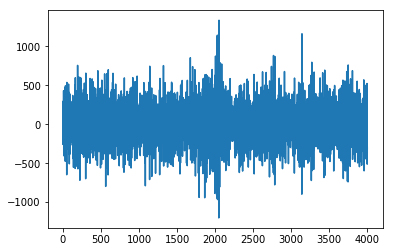

norm_zscore - 전체 / axis=0(시간대별) / axis=1(레코드별)


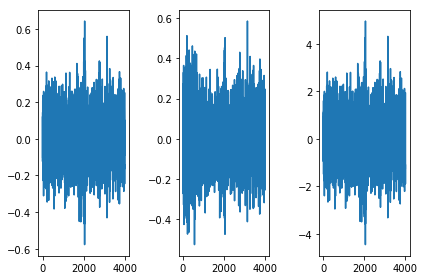

norm_minmax - 전체 / axis=0(시간대별) / axis=1(레코드별)


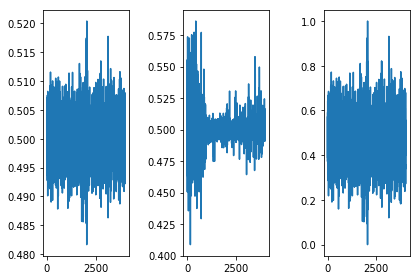

In [12]:
plot_audiodata(train_audio, 3)

In [13]:
def one_hot_encode(label):
    n_label = len(label)
    n_unique_label = len(np.unique(label.asnumpy()))
    res = nd.zeros((n_label, n_unique_label), ctx=ctx)
    res[nd.arange(n_label), label] = 1.0
    return res

In [14]:
train_label_onehot = one_hot_encode(train_label)
print('Shape of train_label_onehot: ', train_label_onehot.shape) #(num_samples, output_dims)

valid_label_onehot = one_hot_encode(valid_label)
print('Shape of valid_label_onehot: ', valid_label_onehot.shape) #(num_samples, output_dims)



Shape of train_label_onehot:  (20972, 2)
Shape of valid_label_onehot:  (9028, 2)


## 2. PreProcessing

##### Comprehension of GRU Block

In [15]:
layer = mx.gluon.rnn.GRU(2, 3) # (num_hidden, num_layers)
layer.initialize()
print('layer', layer)

# GRU INPUT 1 : DATA
input = mx.nd.random.uniform(shape=(5, 1, 10)) # (sequence_length, batch_size, feature_dims)
print("input.shape", input.shape)

# layout (str, default 'TNC') – The format of input and output tensors.
# T, N and C stand for sequence length, batch size, and feature dimensions respectively.

# Expected OUTPUT Shape: (5, 1, 2) # (sequence_length, batch_size, num_hidden)
# Expected RECURRENT STATE Shape: (1, 2, 3) # (num_layers, batch_size, num_hidden)

layer GRU(None -> 6, TNC, num_layers=3)
input.shape (5, 1, 10)


In [16]:
# Manually specify begin state.

# GRU INPUT 2 (Optional) : STATES
h0 = mx.nd.random.uniform(shape=(3, 1, 2)) # (num_layers, batch_size, num_hidden)
output, hn = layer(input, h0)
print("output.shape", output.shape)
print("hn[0].shape", hn[0].shape)

output.shape (5, 1, 2)
hn[0].shape (3, 1, 2)


In [17]:
# By default, zeros are used as begin state
# Same As h0 = nd.zeros(shape=(3, 1, 2)) 
output = layer(input)
print("output.shape", output.shape)

output.shape (5, 1, 2)


##### Comprehension of LSTM Block

In [18]:
layer = mx.gluon.rnn.LSTM(2, 3) # (num_hidden, num_layers)
layer.initialize()
print('layer', layer)

# LSTM INPUT 1 : DATA
input = mx.nd.random.uniform(shape=(5, 1, 10)) # (sequence_length, batch_size, feature_dims)
print("input.shape", input.shape)

# layout (str, default 'TNC') – The format of input and output tensors.
# T, N and C stand for sequence length, batch size, and feature dimensions respectively.

# Expected OUTPUT Shape: (5, 1, 2) # (sequence_length, batch_size, num_hidden)
# Expected RECURRENT STATE Shape: (1, 2, 3) # (num_layers, batch_size, num_hidden)

layer LSTM(None -> 8, TNC, num_layers=3)
input.shape (5, 1, 10)


In [19]:
# Manually specify begin state.

# LSTM INPUT 2 (Optional) : STATES
h0 = mx.nd.random.uniform(shape=(3, 1, 2)) # (num_layers, batch_size, num_hidden)
c0 = mx.nd.random.uniform(shape=(3, 1, 2)) # (num_layers, batch_size, num_hidden)
output, hn = layer(input, [h0, c0])
print("output.shape", output.shape)
print("hn[0].shape", hn[0].shape)

output.shape (5, 1, 2)
hn[0].shape (3, 1, 2)


In [20]:
# By default, zeros are used as begin state
# Same As h0 = nd.zeros(shape=(3, 1, 2)) 

output = layer(input)
print("output.shape", output.shape)

output.shape (5, 1, 2)


In [21]:
batch_size = 32

In [22]:
def generate_batch_data(data, seq_length, dims, batch_size, normalize=None, **kwargs):
    
    data = mx.nd.array(data)
    
    if normalize!=None:
        data = normalize(data, **kwargs)
        
    data = data.reshape((-1, seq_length, dims))
    
    num_batches = len(data) // batch_size    
    
    data_batch = data.reshape((batch_size, num_batches, seq_length, dims))
    data_batch = nd.swapaxes(data_batch, 0, 1) #(num_batches, batch_size, seq_length, feature_dims)
    data_batch = nd.swapaxes(data_batch, 1, 2) #(num_batches, seq_length, batch_size, feature_dims)
    return data_batch





In [23]:
train_x = generate_batch_data(data = train_audio,
                              seq_length = train_audio.shape[1],
                              dims = 1, # 1 Channel (Monophonic)
                              batch_size = batch_size,
                              normalize = norm_zscore,
                              norm_axis = 1
                             )

valid_x = generate_batch_data(data = valid_audio,
                              seq_length = valid_audio.shape[1],
                              dims = 1, # 1 Channel (Monophonic)
                              batch_size = batch_size,
                              normalize = norm_zscore,
                              norm_axis = 1
                             )


train_y = generate_batch_data(data = train_label_onehot,
                              seq_length = 1, # last output
                              dims = train_label_onehot.shape[1],
                              batch_size = batch_size
                             )

valid_y = generate_batch_data(data = valid_label_onehot,
                              seq_length = 1, # last output
                              dims = valid_label_onehot.shape[1],
                              batch_size = batch_size
                             )

In [24]:
print('train_x: ', train_x.shape)
print('valid_x: ', valid_x.shape)
print('train_y: ', train_y.shape)
print('valid_y: ', valid_y.shape)

train_x:  (655, 4000, 32, 1)
valid_x:  (282, 4000, 32, 1)
train_y:  (655, 1, 32, 2)
valid_y:  (282, 1, 32, 2)


## 3. Define Model, Activation, Loss, Optimizer

In [25]:
class RNNModel(gluon.Block):
    """A model with an encoder, recurrent layer, and a decoder."""

    def __init__(self, mode, dims, num_hidden, num_layers, dropout=0.5, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        with self.name_scope():
            self.drop = nn.Dropout(dropout)

            if mode == 'simple_rnn':
                self.rnn = rnn.RNN(num_hidden, num_layers, dropout=dropout, input_size=dims)
            elif mode == 'lstm':
                self.rnn = rnn.LSTM(num_hidden, num_layers, dropout=dropout, input_size=dims)
            elif mode == 'gru':
                self.rnn = rnn.GRU(num_hidden, num_layers, dropout=dropout, input_size=dims)
            else:
                raise ValueError("Invalid mode %s. Options are simple_rnn, lstm, and gru"%mode)
                
            self.flat = nn.Flatten()
            self.dense = nn.Dense(2)
            
    def forward(self, inputs, hidden):
        inputs = self.drop(inputs)
        output, hidden = self.rnn(inputs, hidden)
        output = self.drop(output)
        output = output[len(output)-1]
        output= self.flat(output)
        output= self.dense(output)
        return (output, hidden)

    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)

In [26]:
# Starting each batch, we detach the hidden state from how it was previously produced.
# If we didn't, the model would try backpropagating all the way to start of the dataset.
# (참고) Why we need to detach variable which contains hidden representation
# https://discuss.pytorch.org/t/solved-why-we-need-to-detach-variable-which-contains-hidden-representation/1426

# NDArray.detach: Returns a new NDArray, detached from the current graph.
def detach(hidden):
    if isinstance(hidden, (tuple, list)):
        hidden = [i.detach() for i in hidden]
    else:
        hidden = hidden.detach()
    return hidden

In [27]:
def eval_loss(net, x, y, ibatch, ctx):
    total_L = 0.0
    ntotal = 0
    hidden = model.begin_state(func = mx.nd.zeros, batch_size = batch_size, ctx=ctx)
    data = x[ibatch]
    target = y[ibatch]
    
    with autograd.predict_mode():
        output, _ = net(data, hidden)
        
    L = loss(output, target[-1])
    total_L += mx.nd.sum(L).asscalar()
    ntotal += L.size
    return (total_L, ntotal)


In [28]:
def eval_accuracy(net, x, y, ctx):
    acc = mx.metric.Accuracy()
    
    seq_length = x.shape[1]
    data = nd.swapaxes(x, 0, 1).reshape((seq_length,-1,1)).as_in_context(ctx)    
    label = nd.swapaxes(y, 0, 1).reshape((-1,2)).as_in_context(ctx)
    hidden = model.begin_state(func = mx.nd.zeros, batch_size = label.shape[0], ctx=ctx)

    with autograd.predict_mode():
        output, _ = net(data, hidden)
    
    predictions = mx.nd.argmax(output, axis=1)
    real = mx.nd.argmax(label, axis=1)
    acc.update(preds=predictions, labels=real)

    return acc.get()[1]

## 4. RUN

In [35]:
num_epochs = 1
log_interval = 1
args_clip = 0.2


def train():
    for epoch in range(num_epochs):
        total_L = 0.0
        val_total_L = 0.0
        val_ntotal = 0
        start_time = time.time()
        hidden = model.begin_state(func = mx.nd.zeros, batch_size = batch_size, ctx = ctx)
        for ibatch in range(train_x.shape[0]):
            data = train_x[ibatch]
            target = train_y[ibatch]
            hidden = detach(hidden)
            with autograd.record():
                output, hidden = model(data, hidden)
                L = loss(output, target[-1])
                L.backward()

            grads = [i.grad(ctx) for i in model.collect_params().values()]
            # Here gradient is for the whole batch.
            # So we multiply max_norm by batch_size and bptt size to balance it.
            gluon.utils.clip_global_norm(grads, args_clip * batch_size)

            trainer.step(batch_size)
            total_L += mx.nd.sum(L).asscalar()
            
            val_ibatch = random.sample(range(len(valid_x)), 1)[0]
            batch_val_total_L, batch_val_ntotal = eval_loss(model, valid_x, valid_y, val_ibatch, ctx)
            val_total_L += batch_val_total_L
            val_ntotal += batch_val_ntotal
            val_L = val_total_L / val_ntotal
            
            val_acc = eval_accuracy(model, valid_x, valid_y, ctx)
            
            if ibatch % log_interval == 0 and ibatch > 0:
                cur_L = total_L / batch_size / log_interval
                print('[Epoch %d Batch %d] loss %.2f, validation loss %.2f, validation accuracy %.2f' % (
                    epoch + 1, ibatch, cur_L, val_L, val_acc))
                total_L = 0.0
                
        val_acc = eval_accuracy(model, valid_x, valid_y, ctx)

        print('[Epoch %d] time cost %.2fs, validation loss %.2f, validation accuracy %.2f' % (
            epoch + 1, time.time() - start_time, val_L, val_acc))


In [36]:
model = RNNModel(mode='simple_rnn', dims=train_x.shape[3], num_hidden=5, num_layers=2, dropout=0.3)
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.05, 'momentum': 0, 'wd': 0})
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

train()

[Epoch 1 Batch 1] loss 1.65, validation loss 0.71, validation accuracy 0.50
[Epoch 1 Batch 2] loss 0.66, validation loss 0.70, validation accuracy 0.50
[Epoch 1 Batch 3] loss 0.93, validation loss 0.71, validation accuracy 0.51
[Epoch 1 Batch 4] loss 0.64, validation loss 0.71, validation accuracy 0.51
[Epoch 1 Batch 5] loss 0.73, validation loss 0.70, validation accuracy 0.52
[Epoch 1 Batch 6] loss 0.80, validation loss 0.70, validation accuracy 0.53
[Epoch 1 Batch 7] loss 0.75, validation loss 0.71, validation accuracy 0.53
[Epoch 1 Batch 8] loss 0.78, validation loss 0.71, validation accuracy 0.54
[Epoch 1 Batch 9] loss 0.62, validation loss 0.71, validation accuracy 0.55
[Epoch 1 Batch 10] loss 0.86, validation loss 0.71, validation accuracy 0.55
[Epoch 1 Batch 11] loss 0.65, validation loss 0.71, validation accuracy 0.57
[Epoch 1 Batch 12] loss 0.67, validation loss 0.70, validation accuracy 0.57
[Epoch 1 Batch 13] loss 0.65, validation loss 0.70, validation accuracy 0.58
[Epoch 1

KeyboardInterrupt: 

In [ ]:
model = RNNModel(mode='lstm', dims=train_x.shape[3], num_hidden=5, num_layers=2, dropout=0.3)
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.05, 'momentum': 0, 'wd': 0})
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

train()

In [ ]:
model = RNNModel(mode='gru', dims=train_x.shape[3], num_hidden=5, num_layers=2, dropout=0.3)
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.05, 'momentum': 0, 'wd': 0})
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

train()